# Introduction to NLP at Karakun
## Part 2 - naive Bayes

As an example task throughout this training we use a dataset for sentiment analysis. This dataset contains reviews from the movie plattform **IMDb**. These reviews are labeled as **positive** or **negative**. Our goal for the following tasks is to predict the sentiment of a given review.

Work through this notebook from top to bottom and execute the cells with code. A lot of the code is already prepared. Cells in this notebook which have to be completed with some code snippets are marked with: 

**<font color='red'>!! Call for action !!</font>**.

### Imports

In [26]:
import random
import nltk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas
import numpy as np
from collections import Counter
import itertools
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

# We set a random seed to have reproducible experiments
random.seed(0)

### Define data paths

In [2]:
# Train
train_pos_path = './Sentiment-Analysis-Data/imdb/train-pos.txt'
train_neg_path = './Sentiment-Analysis-Data/imdb/train-neg.txt'

# Test
test_pos_path = './Sentiment-Analysis-Data/imdb/test-pos.txt'
test_neg_path = './Sentiment-Analysis-Data/imdb/test-neg.txt'

### Read data

Here we read the reviews from textfiles. All reviews are written into a list as a **tuple** together with their sentiment. This is the same procedure as in exercise 1.

In [3]:
def read_split_reviews_from_file(file_path, sentiment):
    reviews = []
    
    with open(file_path, 'r') as f:
        for line in f:
            # split text into single words and remove words with length smaller than 2
            review_splitted = [e.lower() for e in line.split() if len(e) >= 2]
            reviews.append((review_splitted, sentiment))
            
    return reviews

In [4]:
# Train
train_reviews_pos = read_split_reviews_from_file(train_pos_path, 'pos')
train_reviews_neg = read_split_reviews_from_file(train_neg_path, 'neg')

# Test
test_reviews_pos = read_split_reviews_from_file(test_pos_path, 'pos')
test_reviews_neg = read_split_reviews_from_file(test_neg_path, 'neg')

In [5]:
# Concatenate positive and negative reviews
train_reviews = train_reviews_pos + train_reviews_neg
test_reviews = test_reviews_pos + test_reviews_neg

In [6]:
# Shuffle the train and test datasets
random.shuffle(train_reviews)
random.shuffle(test_reviews)

In [7]:
N_test= int(len(test_reviews)/2)

eval_reviews = test_reviews[:N_test]
test_reviews = test_reviews[N_test:]

In [8]:
# Check sizes of dataset
print(f'Train size:\t{len(train_reviews)} \nEval size:\t{len(eval_reviews)} \nTest size:\t{len(test_reviews)}')

Train size:	25000 
Eval size:	12500 
Test size:	12500


### Define some helper functions

Find the most common words in a dataset to define which words are used to build the feature vector for a review.

In [9]:
def get_word_features(data, dict_size=2000):
    all_train_words = []
    
    for (words, sentiment) in data:
        all_train_words.extend(words)
    
    # calculate word frequencies
    wordlist = nltk.FreqDist(all_train_words)
    
    # select most common words for dictionary
    word_features = [ w for (w,_) in list(wordlist.most_common())[:dict_size]] 
    
    print(f'Distinct words (train):\t{len(wordlist)}')
    print(f'Word features count: \t{len(word_features)}')
    
    return word_features

One-hot-encode a single review with selected words.

In [10]:
def onehot_encode_review(review, word_features):
    review_words = set(review)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in review_words)
    return features

Confusion matrix utility

In [11]:
def calculate_confusion_matrix(true_values, pred_values):
    
    if len(true_values) != len(pred_values):
        raise ValueError("Lists must have the same length.")
    
    # Get distinct classes
    classes = list(set(true_values + pred_values))
    n_classes = len(classes)
    
    # Create new matrix with zero values with shape (n_classes, n_classes) - (2, 2)
    # Row     (1st dimension): true values
    # Column  (2nd dimension): predicted values
    cm = np.zeros((n_classes, n_classes))
    
    for (true, pred) in zip(true_values, pred_values):      
        row = classes.index(true)
        column = classes.index(pred)
        
        cm[row, column] += 1
        
    return cm, classes

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = plt.text(j, i, "{:d}\n({:0.4f})".format(int(cm[i, j]), cm_normalized[i, j]),
                     horizontalalignment="center",
                     color="white")
            
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Prepare data for a first naive Bayes classifier

We need to determine the word features with the help of the training set once. All other sets must be transformed the same way.

In [13]:
word_features = get_word_features(train_reviews, dict_size=1500)

Distinct words (train):	73966
Word features count: 	1500


In [14]:
train_featureset = [(onehot_encode_review(d, word_features), c) for (d,c) in train_reviews]
eval_featureset  = [(onehot_encode_review(d, word_features), c) for (d,c) in eval_reviews]
test_featureset  = [(onehot_encode_review(d, word_features), c) for (d,c) in test_reviews]

These one hot encoded review representations look like the following: For each word in our dictionary we have the inforamtion if the word is in the review.

In [15]:
part = itertools.islice(test_featureset[0][0].items(), 0, 20)

for key, value in part:
    print (f'{key}\t{value}')

print('...')

contains(the)	True
contains(and)	True
contains(of)	True
contains(to)	True
contains(is)	True
contains(it)	True
contains(in)	True
contains(this)	True
contains(that)	True
contains(was)	False
contains(as)	True
contains(for)	True
contains(with)	True
contains(movie)	True
contains(but)	False
contains(film)	False
contains(you)	False
contains(on)	True
contains(not)	False
contains(he)	True
...


### Train a first model

In [16]:
basic_naive_bayes = nltk.NaiveBayesClassifier.train(train_featureset)

Let's check the accuracy on the evaluation dataset:

In [17]:
print(f'Accuracy: {nltk.classify.accuracy(basic_naive_bayes, eval_featureset)}')

Accuracy: 0.83144


We already achieved an accuracy of **over 83%**.

We can now look into our classifier to find the most informative features (in this case words).

In [18]:
basic_naive_bayes.show_most_informative_features(10)

Most Informative Features
         contains(waste) = True              neg : pos    =     12.5 : 1.0
     contains(pointless) = True              neg : pos    =     10.4 : 1.0
     contains(laughable) = True              neg : pos    =      9.1 : 1.0
         contains(worst) = True              neg : pos    =      9.0 : 1.0
         contains(awful) = True              neg : pos    =      8.4 : 1.0
        contains(poorly) = True              neg : pos    =      8.2 : 1.0
          contains(lame) = True              neg : pos    =      7.0 : 1.0
      contains(pathetic) = True              neg : pos    =      6.4 : 1.0
        contains(wasted) = True              neg : pos    =      6.0 : 1.0
          contains(crap) = True              neg : pos    =      5.9 : 1.0


Let's look at the confusion matrix of this model:

In [19]:
basic_naive_bayes_pred = [basic_naive_bayes.classify(review) for (review, _) in eval_featureset]

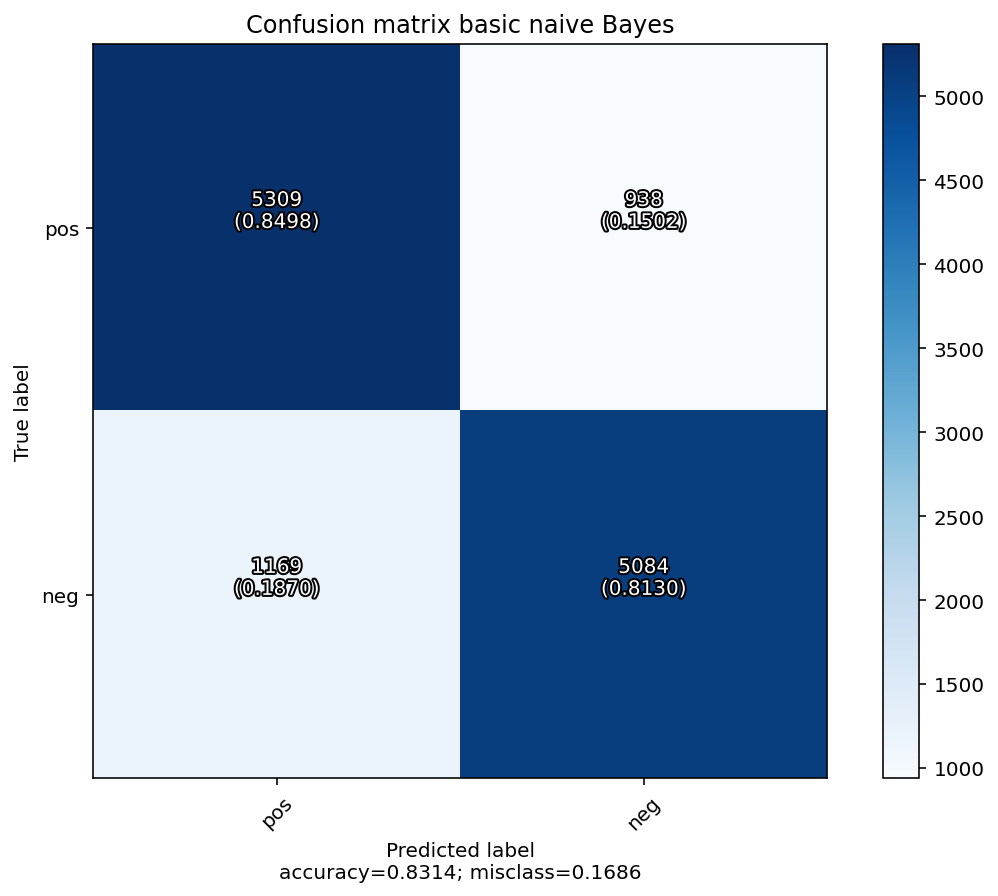

In [22]:
eval_gold = [sent for (_, sent) in eval_featureset ]
cm_basic, classes_basic = calculate_confusion_matrix(eval_gold, basic_naive_bayes_pred)

plot_confusion_matrix(cm_basic, classes_basic, title='Confusion matrix basic naive Bayes')

### Now we try to improve our model

With the help of some preprocessing (stop word removal, lemmatization or stemming...) we should be able to further improve the model.

In [23]:
stopwords_E = stopwords.words('english')

- **Stemming:** `porter.stem('WORD')`
- **Lemmatization:** `lemmatizer.lemmatize('WORD')`

## <font color='red'>!! **Start** - Call for action !!</font>

In [43]:
def preprocess_data(data):
    
    preprocessed = []
    porter = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    for (words, sent) in data:
        
        # TODO : Complete preprocessing of the reviews
        
        # preprocessed_words = [porter.stem(w) for w in words]
        preprocessed_words = [lemmatizer.lemmatize(w) for w in words]
        
        preprocessed_words = [w for w in words if w.isalpha() and w not in stopwords_E]
        
        # TODO : end
        
        preprocessed.append((preprocessed_words, sent))
        
    return preprocessed

## <font color='red'>!! **End** - Call for action !!</font>

In [44]:
train_reviews_preprocessed = preprocess_data(train_reviews)
eval_reviews_preprocessed  = preprocess_data(eval_reviews)
test_reviews_preprocessed  = preprocess_data(test_reviews)

In [45]:
word_features = get_word_features(train_reviews_preprocessed, dict_size=1500)

Distinct words (train):	73068
Word features count: 	1500


In [46]:
train_featureset = [(onehot_encode_review(d, word_features), c) for (d,c) in train_reviews_preprocessed]
eval_featureset  = [(onehot_encode_review(d, word_features), c) for (d,c) in eval_reviews_preprocessed]
test_featureset  = [(onehot_encode_review(d, word_features), c) for (d,c) in test_reviews_preprocessed]

In [47]:
improved_naive_bayes = nltk.NaiveBayesClassifier.train(train_featureset)

In [48]:
print(f'Accuracy: {nltk.classify.accuracy(improved_naive_bayes, eval_featureset)}')

Accuracy: 0.84512


In [49]:
improved_naive_bayes_pred = [improved_naive_bayes.classify(review) for (review, _) in eval_featureset]

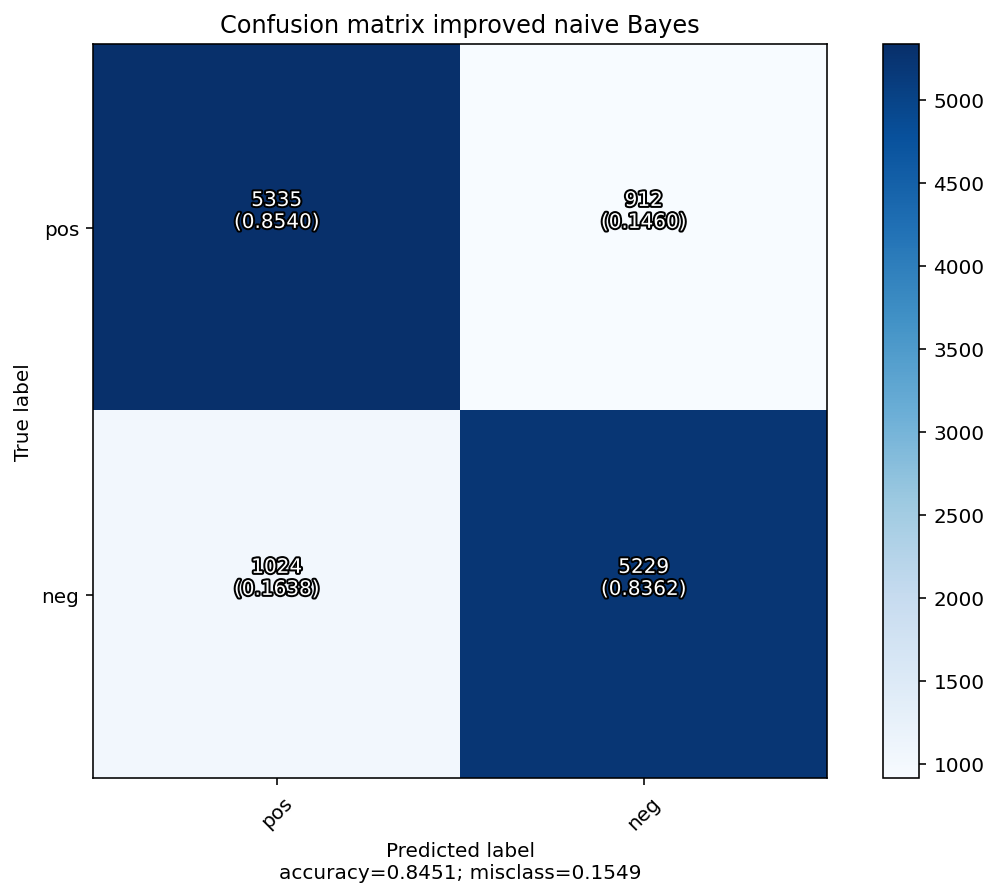

In [50]:
eval_gold = [sent for (_, sent) in eval_featureset ]
cm_improved, classes_improved = calculate_confusion_matrix(eval_gold, improved_naive_bayes_pred)

plot_confusion_matrix(cm_improved, classes_improved, title='Confusion matrix improved naive Bayes')

Did you manage to improve the model on the evaluation dataset? If not try to change your preprocessing and rerun the cells below.

### Check the performance on the test set

After improving our model with the help of the evaluation set we are now allowed to finally test our model with the testset.

In [51]:
print(f'Accuracy: {nltk.classify.accuracy(improved_naive_bayes, test_featureset)}')

Accuracy: 0.84184


In [52]:
improved_naive_bayes_pred_test = [improved_naive_bayes.classify(review) for (review, _) in test_featureset]

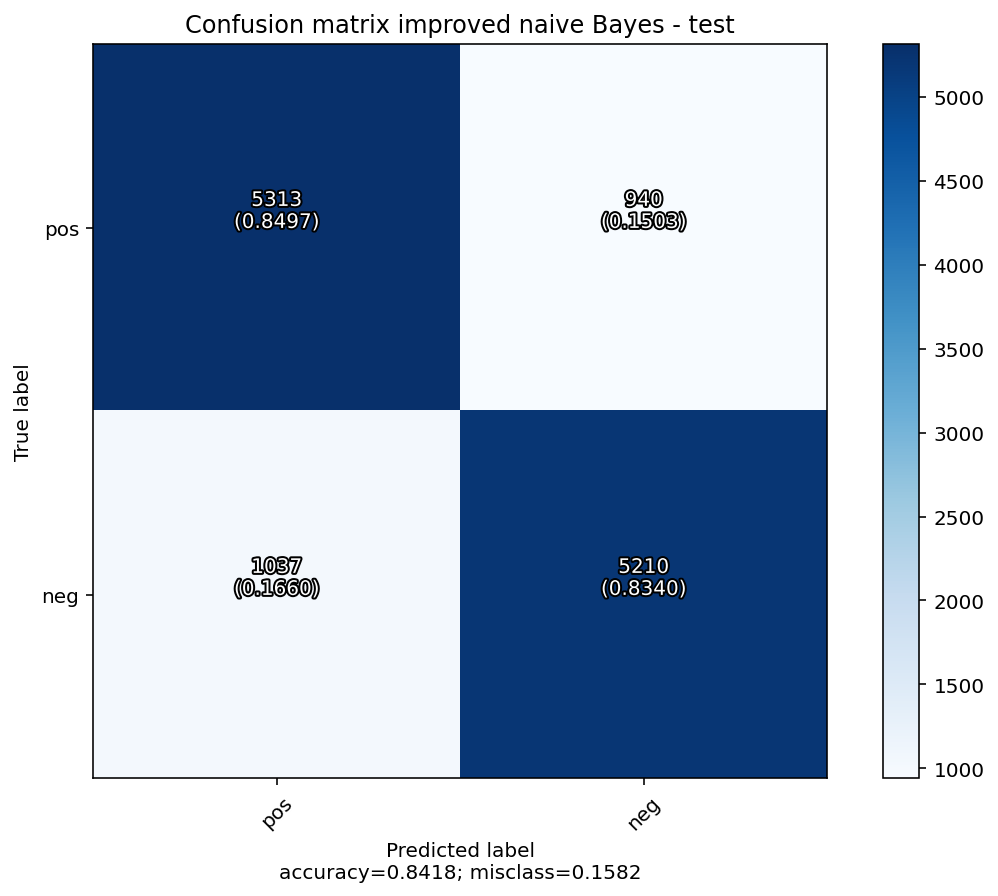

In [53]:
test_gold = [sent for (_, sent) in test_featureset ]
cm_improved_test, classes_improved_test = calculate_confusion_matrix(test_gold, improved_naive_bayes_pred_test)

plot_confusion_matrix(cm_improved_test, classes_improved_test, title='Confusion matrix improved naive Bayes - test')